In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
# import cupy as cp
import math
import time
import nbimporter
from Class_FEA import *
from Class_DataManipulation import *
import util_func
import matplotlib.pyplot as plt
from itertools import product
import subprocess as sp
import os
tf.keras.backend.set_floatx('float64')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from keras import callbacks

In [2]:
# Declare Abaqus job name, file path to job folder, and user subroutine name 
job_name = r"HGO_Tear_Propagation"
job_directory = r"D:\Users\Will\Tear_Propagation_Project"
umat_name = r"UMAT_HGO_C_Damage_Alpha"

# Declare work and data directories
work_directory = r"C:\Users\swilli9\STRETCH_Lab_Projects\Tear_Propagation_Project"
data_directory = r"{path}\Data_and_Visualizations".format(path=work_directory)

# Initialize FEA class to retrieve FEA information that is relevant to ROM
FE = Abaqus(job_name, job_directory, data_directory, BC_file=r"{path}\{job}_BC_mask.csv"
                      .format(path=data_directory,job=job_name))

# Define beta parameters
beta = np.array([[16.75, 40.78],
                 [26.11, 18.85],
                 [69.21, 63.20]])

# Initialize class for handling POD-BFGS functions and storing ROM data
data = FE_Data_M(beta, FE.data_path, FE.BC_mask)

# Initialize storage for time recording
offline_times = dict()
online_times = dict()

SVD_files = False

Uc = np.hstack(data.Uc_mu)

if not SVD_files:
    start = time.time()
    
    Psi, sigma, Phi = np.linalg.svd(Uc)
    
    end = time.time()
    
    cumulative_energy = np.cumsum(sigma)/np.sum(sigma)
    high_energy_index = np.argwhere(cumulative_energy>=0.9999)[0]
    L = int(5*np.ceil(high_energy_index / 5).item())
    
    Psi = Psi[:, :L]
    Phi = Phi[:L, :]
    
    offline_times["SVD"]= end-start
    
    pd.DataFrame(sigma).to_csv(r"{path}_Sigma.csv".format(path=data.data_path))
    pd.DataFrame(Psi).to_csv(r"{path}_Psi.csv".format(path=data.data_path))
    pd.DataFrame(Phi).to_csv(r"{path}_Phi.csv".format(path=data.data_path))
else:
    sigma = pd.read_csv(r"{path}_Sigma.csv".format(path=data.data_path), index_col=0).to_numpy()
    Psi = pd.read_csv(r"{path}_Psi.csv".format(path=data.data_path), index_col=0).to_numpy()
    Phi = pd.read_csv(r"{path}_Phi.csv".format(path=data.data_path), index_col=0).to_numpy()
    
    cumulative_energy = np.cumsum(sigma)/np.sum(sigma)
    high_energy_index = np.argwhere(cumulative_energy>=0.9999)[0]
    L = int(5*np.ceil(high_energy_index / 5).item())


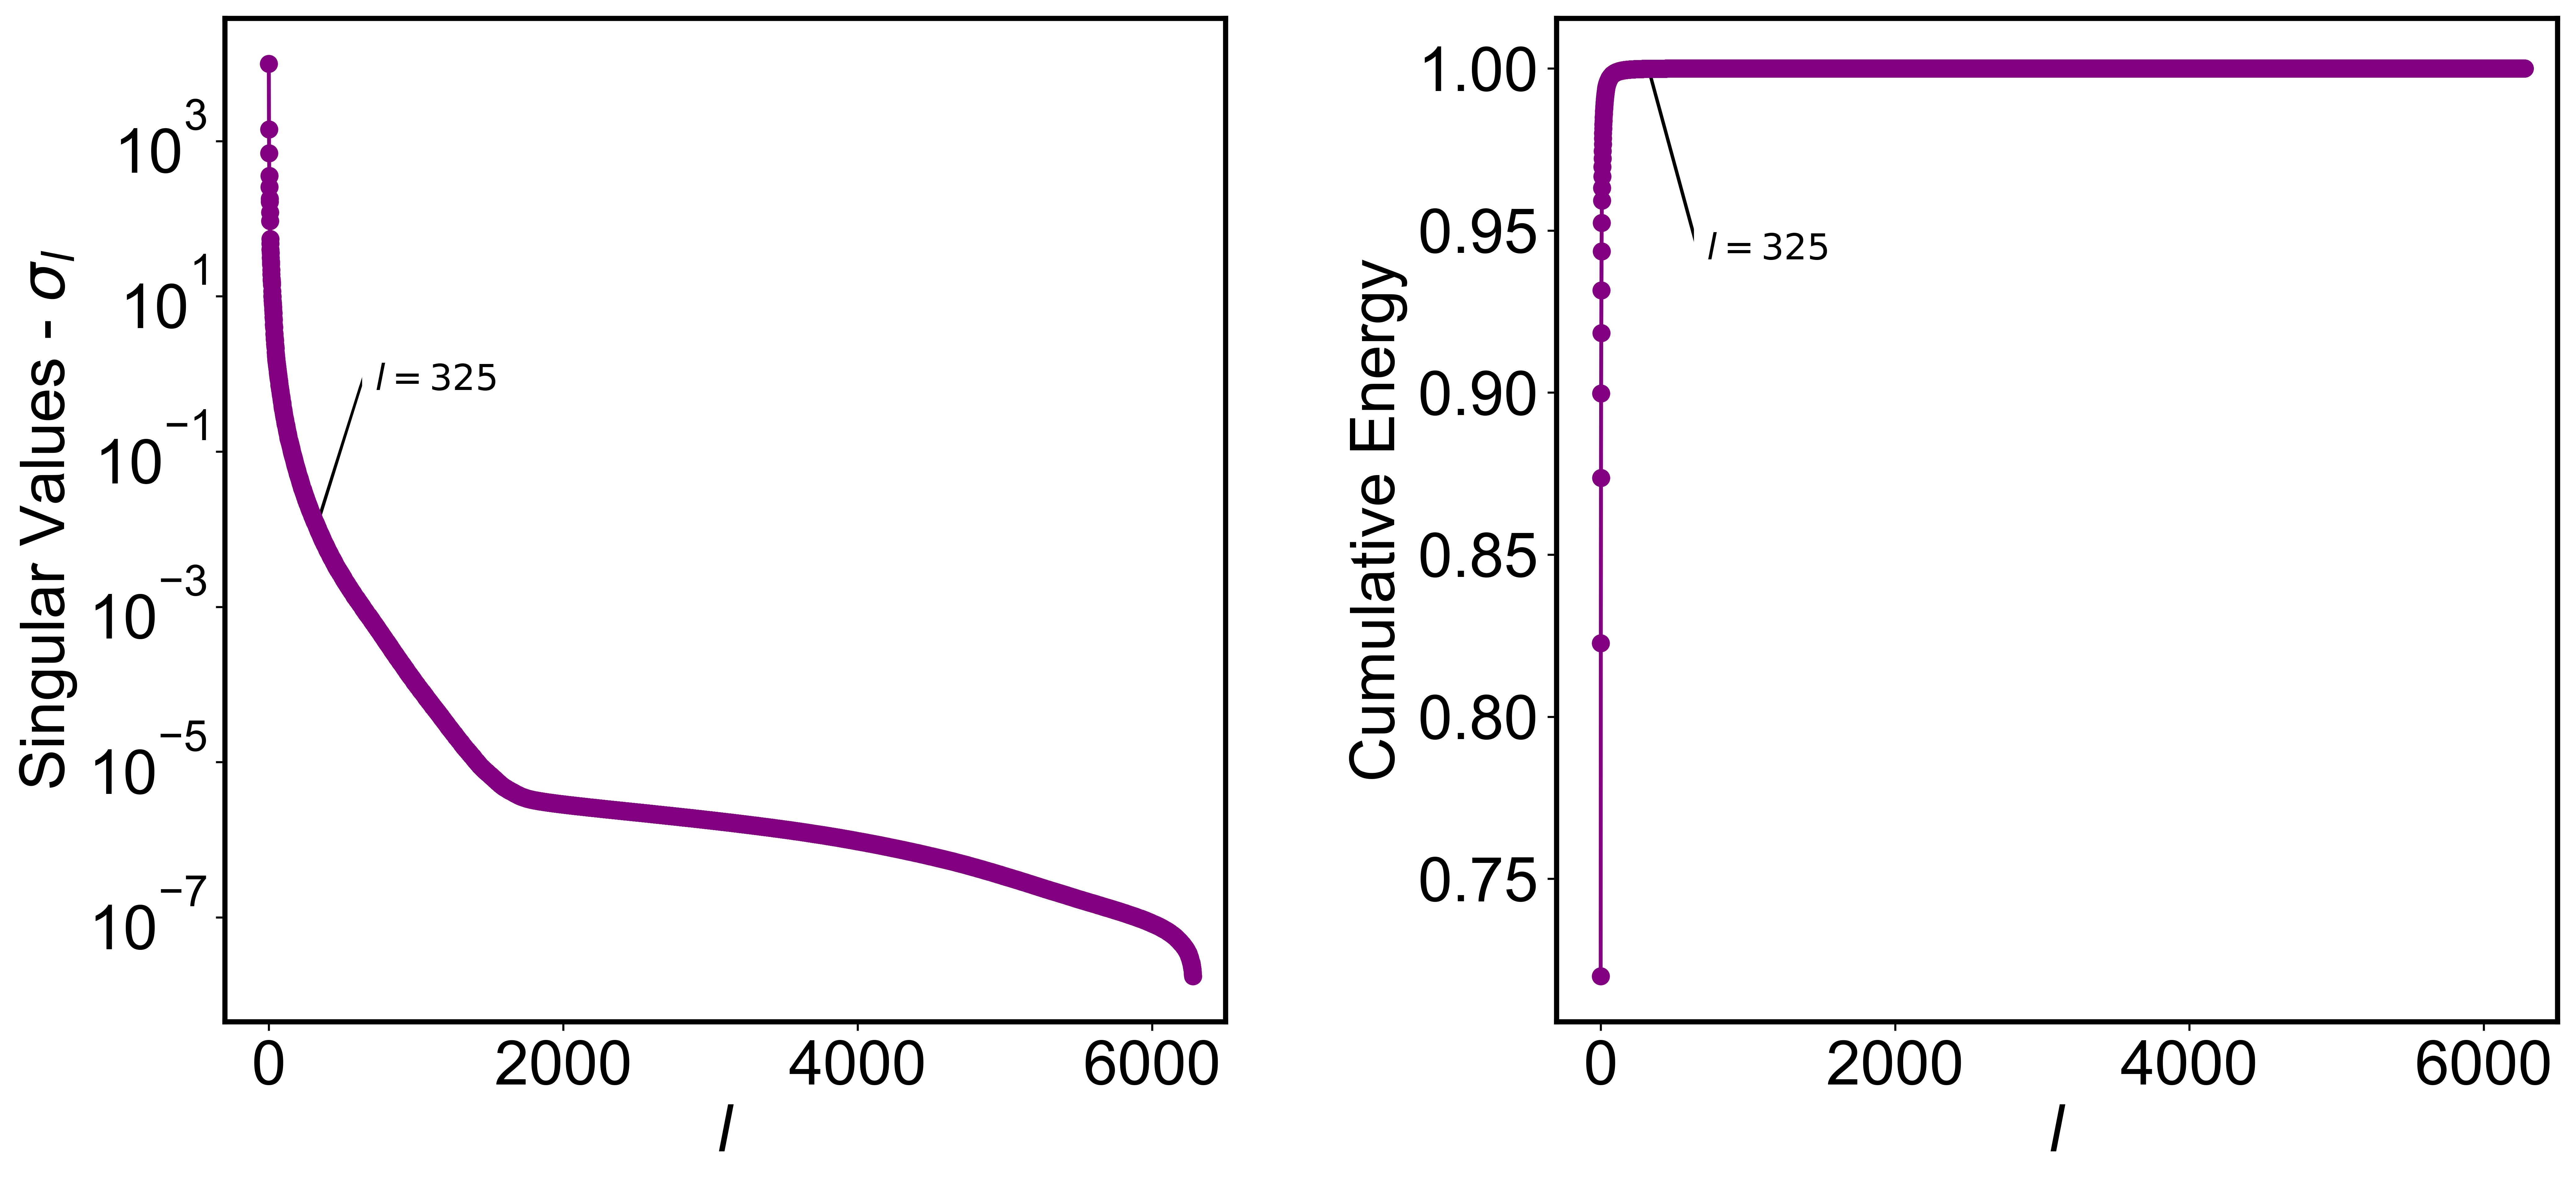

In [3]:
# Plot singular value decay and cumulative energy  
plt.rcParams.update({'font.size':24, 'axes.linewidth':2, 'font.family':'Arial'})

fig, ax = plt.subplots(1,2, figsize=(15,7.5), dpi=600)

ax[0].semilogy(sigma, color='#800080', marker='o', ms=6, mfc='#800080', mec='#800080', linestyle='-')

ax[1].plot(cumulative_energy, color='#800080', marker='o', ms=6, mfc='#800080', mec='#800080', linestyle='-')#, label=leg)

ax[0].arrow(L+300,sigma[L].item()+0.7,-300,-0.7)#l,cp.asnumpy(sigma)[325], l+1,cp.asnumpy(sigma)[325]-1e-4)
#ax[0].arrow(l+300,sigma[3000].item()+0.0007,-300,-0.0007)
ax[1].arrow(L+300,cumulative_energy[L].item()-0.05,-300,+0.05)
ax[0].text(0.15, 0.63, r'$l=325$', transform=ax[0].transAxes, size=14)
ax[1].text(0.15, 0.76, r'$l=325$', transform=ax[1].transAxes, size=14)

ax[0].set_ylabel('Singular Values - $\sigma_{l}$')
ax[1].set_ylabel('Cumulative Energy')
for c in [0, 1]:
    ax[c].set_xlabel('$l$')
    ax[c].set_xlim([-300, 6500])
    ax[c].set_xticks(range(0,6001,2000))
#     ax[c].set_yticks([float(f'1e-{q}') for q in range(1,7)])
#     ax[c].set_ylim([float(f'5e-7'), float(f'2e-1')])
#     ax[c].legend(loc='best', fontsize=20, ncol=2, markerscale = 1.5, columnspacing=0.8, 
#              handletextpad=0.1, borderpad=0.3, framealpha=1, edgecolor='black')

fig.tight_layout(pad=2.0)
fig.savefig(r"{path}_sigma_decay_and_cumulative_energy.eps".format(path=data.data_path))


In [44]:
# A general class for constructing neural network architecture
class NN_Architecture(tf.keras.Model):
    def __init__(self,
            num_hidden_layers=2, 
            num_neurons_per_layer=2**7,
            output_dim=1,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42),
            bias_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=42),
            **kwargs):
        
        # Intialize superclass with its default parameter signature
        super().__init__(**kwargs)
        
        # Store hyperparameters
        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim     
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer, 
                             bias_initializer=bias_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    
    # Mimic functionality of model(x)
    def call(self, X):
        #Forward-pass through neural network.
        Z = self.hidden[0](X)
        for i in range(1, self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

    
    

class POD_ML_Solver:
    def __init__(self, X, Y, model_c, C, psi_T, model_i=None, I=None, alpha=1):
        
        self.model_c = model_c
        self.model_i = model_i
        
        self.x = X
        self.y = Y
        
        self.c = C
        self.i = ~C
        
        self.psi_T = psi_T
        
        self.a = alpha
          
    
    # Enforce system and Schwarz boundaries weakly 
    def get_loss_wdbc(self, x):
        
        ground_truth = tf.matmul(self.y, self.psi_T)
        u_pred1 = tf.matmul(self.model_c(x), self.psi_T)
        
        temp_0 = tf.math.reduce_sum(tf.square( u_pred1 - ground_truth ), axis=1)
        temp_1 = tf.math.reduce_sum(tf.square( ground_truth ), axis=1)
        self.phi_s = tf.sqrt(tf.math.reduce_sum(temp_0/temp_1))
        
        # Compute phi_c
        temp_0 = tf.math.reduce_sum(tf.square( self.model_c(x) - self.y ), axis=1)
        temp_1 = tf.math.reduce_sum(tf.square( self.y ), axis=1)
        phi_c = tf.sqrt(tf.math.reduce_sum(temp_0/temp_1))
#         phi_c = self.a*tf.math.reduce_mean(tf.square(  ))
#         phi_c = self.a*tf.math.reduce_mean(tf.square( tf.boolean_mask(u_pred1, self.c, axis=1) 
#                                                - tf.boolean_mask(ground_truth, self.c, axis=1) ))
            
        # Initialize loss with current domain loss
        loss = phi_c

        phi_i = 0
        # Calculate interface loss for current model if applicable
        if self.model_i:
            u_pred2 = tf.matmul(self.model_i(x), self.psi_T)
            phi_i += (1 - self.a) * tf.reduce_mean(tf.square(tf.boolean_mask(u_pred1, self.i, axis=1) 
                                                           - tf.boolean_mask(u_pred2, self.i, axis=1)))

        # Add phi_i to the loss
        loss += phi_i

        return loss, phi_c, phi_i

    
    
    def get_gradient(self, x):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with respect to trainable variables
            tape.watch(self.model_c.trainable_variables)
            
            loss, _, _ = self.get_loss_wdbc(x)

        g = tape.gradient(loss, self.model_c.trainable_variables)

        return g
    
    
    def solve(self, optimizer, numEpochs, batch_size):

        @tf.function
        def train_step(x):
            # Retrieve loss gradient w.r.t. trainable variables
            grad_theta = self.get_gradient(x)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model_c.trainable_variables))

        # Split data into training batches
#         train_dataset = tf.data.Dataset.from_tensor_slices((self.x,))
#         train_dataset = train_dataset.shuffle(buffer_size=6279).batch(batch_size)
 
        # Iterate training
        for i in range(numEpochs):
            
            # Train on each batch
#             for (x_batch_train,) in train_dataset:
#                 train_step(x_batch_train)
            train_step(self.x)
            
            # Compute loss for full dataset to track training progress
        self.loss, self.phi_c, self.phi_i = self.get_loss_wdbc(self.x)


In [45]:
ML_type = "POD" #"CNN"
Schwarz = False
lr = 1e-3
numEpochs = 2**12
batch_size = Uc.shape[1]
  
C_mask = np.array([True]*len(Psi))

if ML_type == "POD":
    
    xPOD = tf.constant(np.hstack((np.vstack(data.beta_mu), np.expand_dims(np.hstack(data.times_mu), axis=1))))
    input_dim = 4


    for l in range(50,51):#range(325,L+1):
        psi_T = tf.constant(np.transpose(Psi[:,:l]))
        
        yPOD = tf.constant(np.matmul(np.transpose(Phi[:l, :]), np.diag(sigma[:l])))
        
        pod_ml_model = NN_Architecture(num_hidden_layers=2, num_neurons_per_layer=2**8, output_dim = l)
        pod_ml_model.build(input_shape=(None, input_dim))
    
        pod_ml_solver = POD_ML_Solver( xPOD, yPOD, pod_ml_model, C_mask, psi_T )
    
        pod_ml_solver.solve(tf.keras.optimizers.Adam(learning_rate=lr), numEpochs, batch_size)

        print(pod_ml_solver.loss)
        print(pod_ml_solver.phi_s)
        
        
elif ML_type == "CNN":
    print("hello world")

model_predict = tf.function(pod_ml_model)

print(model_predict(xPOD))
print(yPOD)


tf.Tensor(18.825347498650796, shape=(), dtype=float64)
tf.Tensor(18.825347498650796, shape=(), dtype=float64)
tf.Tensor(
[[-1.72515715e-01 -2.88691432e-02 -1.42800980e-02 ...  8.69840724e-03
  -4.21326458e-03  6.73473941e-03]
 [-1.77726286e-01 -2.90657828e-02 -1.44979507e-02 ...  8.73688990e-03
  -4.16467632e-03  6.77473005e-03]
 [-1.85542142e-01 -2.93607420e-02 -1.48247299e-02 ...  8.79461390e-03
  -4.09179395e-03  6.83471601e-03]
 ...
 [-1.44438631e+02  3.60045991e+01  1.13181105e+01 ...  4.22761803e-02
  -1.29162019e-02 -5.36395817e-03]
 [-1.45729391e+02  3.88205910e+01  1.15102654e+01 ...  4.67380845e-02
  -1.38007219e-02 -4.53397628e-03]
 [-1.46973039e+02  4.15337991e+01  1.16954066e+01 ...  5.10371291e-02
  -1.46529570e-02 -3.73428872e-03]], shape=(6279, 50), dtype=float64)
tf.Tensor(
[[-4.39559105e-02 -1.53910598e-02 -9.63887129e-04 ... -1.97056707e-03
  -6.20153963e-04 -1.14564238e-03]
 [-1.17172310e-01 -3.96960406e-02 -7.79206160e-03 ... -5.56503993e-03
  -1.79590591e-03 -3.32

In [32]:
ground_truth = tf.matmul(yPOD, psi_T)
u_pred1 = tf.matmul(model_predict(xPOD), psi_T)

temp_0 = tf.math.reduce_sum(tf.square( u_pred1 - ground_truth ), axis=1)
temp_1 = tf.math.reduce_sum(tf.square( ground_truth ), axis=1)
phi_s = tf.sqrt(tf.math.reduce_sum(temp_0/temp_1))
phi_c = tf.math.reduce_sum(tf.math.reduce_sum(tf.square( u_pred1 - ground_truth ), axis=1),axis=0)

print(phi_s)

tf.Tensor(5425.896017659163, shape=(), dtype=float64)


In [ ]:
# K_red_file = False # Control whether K_red_0 is computed here or read from a pre-existing file

# if not K_red_file:
#     start = time.time()

#     K_red_0 = ROM.get_K_red_0(psi, l)

#     end = time.time()

#     offline_times["K_red_0"] = end-start

#     #K_red_0[0] = cp.squeeze(K_red_0[0])

#     #cp.savez("{path}_K_red_0".format(path=ROM.data_path), *K_red_0)
# else:
#     container = cp.load("{path}_K_red_0.npz".format(path=ROM.data_path))
#     K_red_0 = [container[key] for key in container.files]




# combination = beta.shape[1]**beta.shape[0]
# zeta_list = [[None]*combination for i in range(l)]
# Uc_ROM = [cp.zeros_like(u) for u in ROM.Uc_mu]

# for i in range(1):
#     t = cp.array([ROM.times_mu[i]])
    
#     Fc_n = ROM.Fc_mu[i]
#     Fc = tf.constant(cp.hstack((cp.zeros_like(Fc_n),cp.matmul(Fc_n, t))))
    
#     Uc = tf.constant(cp.hstack((cp.zeros_like(Fc_n),ROM.Uc_mu[i])))
    
#     for k in range(1,2):
#         K_red_j_minus_1 = tf.constant(K_red_0[k][i])
        
#         I = tf.eye(k+1, dtype=tf.dtypes.float64)
        
#         Psi_l = tf.constant(psi[:,:k+1])
        
#         for j in range(1,2):#Fc.shape[1]+1):
#             du = tf.matmul(tf.transpose(Psi_l),Uc[:,j:j+1] - Uc[:,j-1:j])
#             dr = tf.matmul(tf.transpose(Psi_l), Fc[:,j:j+1] - Fc[:,j-1:j])
            
#             dudrT = tf.matmul(du, tf.transpose(dr))/tf.matmul(tf.transpose(dr), du)
#             drduT = tf.matmul(dr, tf.transpose(du))/tf.matmul(tf.transpose(du), du)
#             duduT = tf.matmul(du, tf.transpose(du))/tf.matmul(tf.transpose(dr), du) 
            
#             K_red_j_inv = tf.linalg.matmul(tf.linalg.matmul((I-drduT), 
#                                                             tf.linalg.inv(K_red_j_minus_1)),
#                                                             (I-dudrT)) + duduT
        
#             Fc_red = tf.matmul(tf.transpose(Psi_l),Fc[:,j:j+1])
            
#             zeta = tf.matmul(K_red_j_inv, Fc_red)
            
#             Uc_ROM[i][:,j-1:j] = tf.matmul(Psi_l,zeta).numpy()
            
#             print(Uc_ROM[i][:,j-1:j])
#             print(Uc[:,j-1:j])
        



# Kc_0 = pd.read_csv(r"{path}_Kc0_{b_d}_{b_m}_{b_p}.csv"
#                                 .format(path=ROM.data_path,b_d=16.75,b_m=26.11,b_p=69.21), index_col=0).to_numpy()

# print((Kc_0.transpose() == Kc_0).all())

# ev = np.linalg.eigvals(Kc_0)

# print((ev > 0).all())

In [ ]:
# @tf.function
# def get_POD_basis(A):
#     #with tf.device('/GPU:0'):
#     covariance = tf.matmul(tf.transpose(A),A)

#     L, V = tf.linalg.eig(covariance)
#     Lambda = tf.sort(tf.math.real(L))[::-1]
#     L_arg = tf.argsort(tf.math.real(L))[::-1]

#     phi = tf.gather(tf.math.real(V), indices=L_arg, axis=1)

#     sigma = tf.math.sqrt(Lambda)
#     sigma = tf.where(tf.math.is_nan(sigma), tf.zeros_like(sigma), sigma)
# #         sigma_inv = cp.diag(sigma**-1)

# #         psi = cp.matmul(cp.matmul(A, phi[:, :sigma.shape[0]]), sigma_inv)

#     return sigma#, psi

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

print(get_gpu_memory())